In [2]:
import pandas as pd

# Prepair Data

In [3]:
whisper_intent = pd.read_csv("../assistant/data/whisper_intents.csv")
whisper_intent

,messages,intent
0,Can you speak to me?,Whisper on
1,Enable voice responses.,Whisper on
2,Turn on voice replies.,Whisper on
3,Can you reply with your voice?,Whisper on
4,Activate audio responses.,Whisper on
...,...,...
395,Turn on text replies only.,Whisper off
396,I prefer text answers.,Whisper off
397,Disable voice responses.,Whisper off
398,Can you answer using text instead?,Whisper off


In [4]:
common_intent_df = pd.read_csv("../assistant/data/common_intents.csv")
common_intent_df

,messages,intent
0,What's the weather like today?,Negative
1,What's the price of gold today?,Negative
2,I want to book a flight ticket.,Negative
3,Can you tell me the current exchange rate?,Negative
4,How do I cook pho?,Negative
...,...,...
1639,Enumerate your range of capabilities.,Ask Features
1640,Describe what kind of tasks you can handle.,Ask Features
1641,Detail the functions you excel in.,Ask Features
1642,Explain your range of assistance.,Ask Features


In [26]:
# Shuffle DataFrame common_intent_df
common_intent_df = common_intent_df.sample(frac=1).reset_index(drop=True)

# 400 sample
sampled_common_messages = common_intent_df['messages'].head(400)

whisper_intent_extent = whisper_intent.copy()
whisper_intent_extent['messages'] = whisper_intent['messages'] + ' ' + sampled_common_messages


In [27]:
mapping = {
    "Whisper on": "whisperon_n_intent",
    "Whisper off": "whisperoff_n_intent"
}

whisper_intent_extent['intent'] = whisper_intent_extent['intent'].map(mapping)

In [28]:
whisper_intent_extent = pd.concat([whisper_intent_extent, whisper_intent], ignore_index=True)
whisper_intent_extent

,messages,intent
0,Can you speak to me? How can I support educati...,whisperon_n_intent
1,Enable voice responses. Take me to the course ...,whisperon_n_intent
2,Turn on voice replies. How difficult is the Vi...,whisperon_n_intent
3,Can you reply with your voice? Display the lan...,whisperon_n_intent
4,Activate audio responses. Search for courses i...,whisperon_n_intent
...,...,...
795,Turn on text replies only.,Whisper off
796,I prefer text answers.,Whisper off
797,Disable voice responses.,Whisper off
798,Can you answer using text instead?,Whisper off


In [29]:
# Shuffle DataFrame common_intent_df
common_intent_df = common_intent_df.sample(frac=1).reset_index(drop=True)

# 500 sample
sampled_common_intent_df = common_intent_df.sample(n=500)
sampled_common_intent_df['intent'] = 'Common'
sampled_common_intent_df
train_whisper_intents = pd.concat([whisper_intent_extent, sampled_common_intent_df], ignore_index=True)


In [5]:
# train_whisper_intents.to_csv("../assistant/data/train_whisper.csv", index=False)

NameError: name 'train_whisper_intents' is not defined

In [31]:
train_whisper_intents = train_whisper_intents.sample(frac=1).reset_index(drop=True)
train_whisper_intents

,messages,intent
0,I prefer written answers.,Whisper off
1,Enable your voice responses.,Whisper on
2,How do I set up a home Wi-Fi network?,Common
3,"Hi, need some guidance",Common
4,Can you talk out loud to me?,Whisper on
...,...,...
1295,Switch off audio mode.,Whisper off
1296,Can you answer with text?,Whisper off
1297,Switch on voice mode. Which skills will I lear...,whisperon_n_intent
1298,How do I create a meal plan?,Common


# Init model

In [28]:
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, RobertaModel, TrainingArguments, Trainer

In [29]:
# define RoBERTa model
roberta_tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")
roberta_model = RobertaModel.from_pretrained("FacebookAI/roberta-base")

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
train_whisper_intents = pd.read_csv("../assistant/data/train_whisper.csv")
train_whisper_intents = train_whisper_intents.sample(frac=1).reset_index(drop=True)
train_whisper_intents

,messages,intent
0,Start talking responses.,Whisper on
1,Can you explain your range of support?,Common
2,Deactivate your voice mode. How do I support e...,whisperoff_n_intent
3,How do I create a vision board?,Common
4,Enable audio replies. Enumerate your areas of ...,whisperon_n_intent
...,...,...
1297,Use your voice for answers. Search for courses...,whisperon_n_intent
1298,Switch on voice responses. How do I know if a ...,whisperon_n_intent
1299,Display the course overview for Innovation Man...,Common
1300,Which skills will I learn in the German Langua...,Common


In [31]:
intents = {
    'Whisper on': 0,
    'Whisper off': 1,
    'whisperon_n_intent': 2,
    'whisperoff_n_intent': 3,
    'Common': 4,
}   
for item in train_whisper_intents["intent"]:
    if item not in intents:
        print(f"intent value '{item}' not found in intents dictionary.")

In [32]:
train_data, test_data = train_test_split(train_whisper_intents, test_size=0.2, random_state=42)

def prepare_input_data(data):
    encoded_data = roberta_tokenizer(data["messages"].tolist(), padding=True, truncation=True, return_tensors="pt")
    return encoded_data

In [33]:
train_inputs = prepare_input_data(train_data)
test_inputs = prepare_input_data(test_data)

train_labels = torch.tensor([intents[item] for item in train_data["intent"]])
test_labels = torch.tensor([intents[item] for item in test_data["intent"]])

print(len(train_inputs['input_ids']))
print(len(train_labels))

1041
1041


In [34]:
class WhisperIntentClassifier(nn.Module):
    def __init__(self, bert_model, num_classes):
        super(WhisperIntentClassifier, self).__init__()
        self.bert = bert_model
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        x = self.relu1(pooled_output)
        x = self.relu2(x)
        logits = self.fc(x)
        return logits
    
num_classes = 5
model = WhisperIntentClassifier(roberta_model, num_classes)

# Check if GPU is available and move the model to GPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Selected Device:", device)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

Selected Device: mps


In [35]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    print("Selected Device:", device)
    device = torch.device("mps")


Selected Device: mps


In [36]:
# Define batch size
batch_size = 32

# Create DataLoader for training data
train_dataset = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], train_labels)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [37]:
num_epochs = 5
# Train the model
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_data_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch + 1}/{num_epochs}, Average Loss: {total_loss / len(train_data_loader)}')

Epoch 1/5, Average Loss: 1.3426030946500374
Epoch 2/5, Average Loss: 0.616707542628953
Epoch 3/5, Average Loss: 0.20013846118341794
Epoch 4/5, Average Loss: 0.06405056177666693
Epoch 5/5, Average Loss: 0.055487874669559074


In [38]:
# Evaluation
model.eval()
with torch.no_grad():
    # Move input data to the device
    test_input_ids = test_inputs['input_ids'].to(device)
    test_attention_mask = test_inputs['attention_mask'].to(device)
    
    # Forward pass
    logits = model(test_input_ids, test_attention_mask)
    predicted_labels = torch.argmax(logits, dim=1)
    
    # Move predicted labels back to CPU for accuracy calculation
    predicted_labels = predicted_labels.cpu()
    
    # Calculate accuracy
    accuracy = accuracy_score(test_labels, predicted_labels)
    print(f'Accuracy on test set: {accuracy * 100:.2f}%')

Accuracy on test set: 96.93%


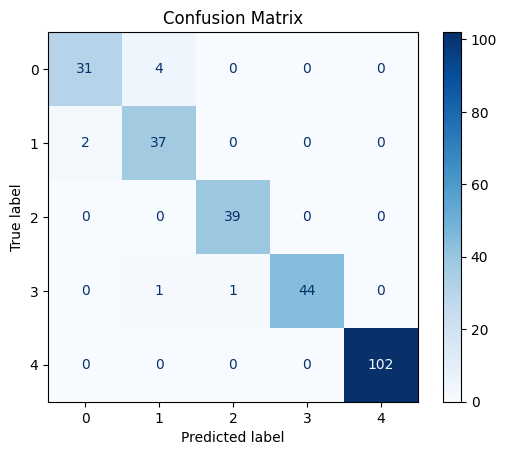

In [39]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

true_labels = test_labels.numpy() if isinstance(test_labels, torch.Tensor) else test_labels
pred_labels = predicted_labels.numpy() if isinstance(predicted_labels, torch.Tensor) else predicted_labels

# confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [43]:
# Save model state_dict
torch.save(model.state_dict(), 'models/whisper_intents/whisper_intent_model.pt')
# Save tokenizer
roberta_tokenizer.save_pretrained('models/whisper_intents/whisper_intent_tokenizer')

# Save model state_dict
torch.save(model.state_dict(), '../ui/services/intent_handlers/models/whisper_intents/whisper_intent_model.pt')
# Save tokenizer
roberta_tokenizer.save_pretrained('../ui/services/intent_handlers/models/whisper_intents/whisper_intent_tokenizer')

('../ui/services/intent_handlers/models/whisper_intents/whisper_intent_tokenizer/tokenizer_config.json',
 '../ui/services/intent_handlers/models/whisper_intents/whisper_intent_tokenizer/special_tokens_map.json',
 '../ui/services/intent_handlers/models/whisper_intents/whisper_intent_tokenizer/vocab.json',
 '../ui/services/intent_handlers/models/whisper_intents/whisper_intent_tokenizer/merges.txt',
 '../ui/services/intent_handlers/models/whisper_intents/whisper_intent_tokenizer/added_tokens.json',
 '../ui/services/intent_handlers/models/whisper_intents/whisper_intent_tokenizer/tokenizer.json')

In [44]:
def predict_intents(sentence, model, tokenizer, tense_labels, device):
    # Move model and tokenizer to the specified device
    model = model.to(device)
    tokenizer = tokenizer
    
    # Tokenize the sentence
    encoded_sentence = tokenizer(sentence, padding=True, truncation=True, return_tensors="pt").to(device)
    
    with torch.no_grad():
        # Forward pass
        logits = model(encoded_sentence['input_ids'], encoded_sentence['attention_mask'])
        predicted_label = torch.argmax(logits, dim=1).item()
    
    # Get the predicted tense label
    predicted_intent = [k for k, v in tense_labels.items() if v == predicted_label][0]
    
    return predicted_intent

# Specify the device (e.g., 'cuda', 'mps' for GPU or 'cpu' for CPU)
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
sentence_to_predict = """
Hello
"""
predicted_intent = predict_intents(sentence_to_predict, model, roberta_tokenizer, intents, device)
print(f"The predicted whisper intent for the sentence is: {predicted_intent}")


The predicted whisper intent for the sentence is: Common
